In [2]:
from qutip import *
from qutip.qip.operations import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
from random import random 
from tqdm import tqdm
%matplotlib inline

In [3]:
def solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False):
    tau_m = 3e-3
    H0 = -1j*etaOmega/2 * tensor(sigmap(), create(Nmax))    
    def H0_coeff(t, args):
        return np.exp(-1j*delta*np.sin(w*t+phi)*t)

    H1 = 1j*etaOmega/2 * tensor(sigmam(), destroy(Nmax))  
    def H1_coeff(t, args):
        return np.exp(1j*delta*np.sin(w*t+phi)*t)

    H = [[H0, H0_coeff], [H1, H1_coeff]]

    c_ops = [tensor(qeye(2), np.sqrt(1/tau_m)*create(Nmax)*destroy(Nmax))]
    #c_ops = []
    if waiton:
        output = mesolve(tensor(qeye(2),qeye(Nmax)), s_init, t_list, c_ops, [])
    else:
        output = mesolve(H, s_init, t_list, c_ops, [])
    
    '''sz = []
    for i in range(len(output.states)):
        sz.append((output.states[i].ptrace(0)*sigmaz()).tr())
    plt.plot(t_list, sz)'''
    
    return output

In [4]:
import random as rd
def CPMG(tau, delta = 0, w = 0, loop = 4):  
    Nmax = 10
    nth = 0.0
    s0 = tensor(ket2dm(basis(2,1)),thermal_dm(Nmax, nth))
    #s0 = tensor(ket2dm(basis(2,1)),coherent_dm(Nmax, 2))
    
    t0 = 0.1e-3 # ms, pi time
    etaOmega = np.pi/t0/np.sqrt(1+nth)
    phi = rd.random()*2*np.pi
    
    # First step: pi/2 rotation
    t_start = 0
    t_stop = t0/2 #pi/2
    N_sample = 100

    s_init = s0
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False)

    s_out = output.states[-1]

    for i in range(loop):
        # Wait
        if tau != 0:    
            t_start = t_stop
            if i == 0:
                t_stop = t_start + tau/2
            else:
                t_stop = t_start + tau
            N_sample = 100
            t_list = np.linspace(t_start, t_stop, N_sample)
            s_init = s_out

            output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = True)
            s_out = output.states[-1]

        # Pi rotation
        t_start = t_stop
        t_stop = t_start + t0
        N_sample = 100
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s_out

        output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False)

        s_out = output.states[-1]
  
    # Wait
    if tau != 0:    
        t_start = t_stop
        t_stop = t_start + tau/2
        N_sample = 100
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s_out

        output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = True)
        s_out = output.states[-1]
        
    # Pi/2 rotation    
    t_start = t_stop
    t_stop = t_start + t0/2 #pi/2
    N_sample = 100

    s_init = s_out
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False)

    s_final = output.states[-1].ptrace(0)
    return ((s_final*sigmaz()).tr()+1)/2
    #s5 = output.states[-1]
    #return [s0, s1, s2, s3, s4, s5]

def scan_wait_time(tau_list, delta, w, loop):
    probs = []
    for tau in tqdm(tau_list):
        exp = 50
        rs = 0
        for i in range(exp):
            rs += CPMG(tau, delta, w, loop)
        prob = rs/exp
        probs.append(prob)
         
    plt.figure()
    plt.plot(tau_list, probs, 'b-', label = 'exp', )
    plt.axhline(y = 0.5*(1+1/np.exp(1)), label = '1/e', color='r', linestyle='-')
    plt.axhline(y = 0.5, label = 'y = 0.5', color='g', linestyle='--')
    plt.ylim([-0.1,1.1])
    plt.legend()

In [5]:
tau_list = np.linspace(0,10e-3,11)
scan_wait_time(tau_list, delta = 0, w = 0)

TypeError: scan_wait_time() missing 1 required positional argument: 'loop'

In [ ]:
tau_list = np.linspace(0,10e-3,11)
scan_wait_time(tau_list, delta = 1e3, w = 200)

100%|██████████| 51/51 [04:10<00:00,  4.90s/it]


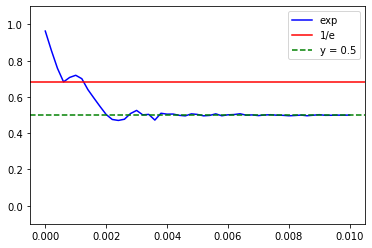

In [52]:
tau_list = np.linspace(0,10e-3,51)
scan_wait_time(tau_list, delta = 5e3, w = 200)

100%|██████████| 51/51 [16:13<00:00, 19.08s/it]


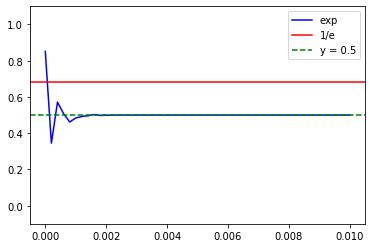

In [54]:
tau_list = np.linspace(0,10e-3,51)
scan_wait_time(tau_list, delta = 5e3, w = 200, loop = 20)

# Filter function

In [94]:
def FF(w, tau, N):
    tauList = []
    tauList.append(0)
    tauList.append(tau/2)
    for i in range(N-1):
        t_append = tauList[-1]+tau
        tauList.append(t_append)
    t_append = tauList[-1]+tau/2
    tauList.append(t_append)
    
    ss = 0
    for i in range(len(tauList)):        
        ss += 2*(-1)**i*np.exp(1j*w*tauList[i])
    ss = ss-1-(-1)**(len(tauList))*np.exp(1j*w*tauList[-1])
    ss = ss/w
    return ss

def ffAmp(tau_list, N):
    f_center = []
    amp = []
    for tau in tau_list:
        ws = np.linspace(0.3/tau*2*np.pi,1/tau*2*np.pi,1001)
        ff_data = [np.abs(FF(w, tau, N))**2 for w in ws]
        idx = np.argmax(ff_data)
        f_center.append(ws[idx]/2/np.pi)
        amp.append(np.trapz(ff_data, ws))
    return f_center, amp

In [95]:
def getFreq(time_list):
    return [1/time_list[i]/2 for i in range(len(time_list))]

def NoiseSpectrum(data):
    waitTime = data[0]
    Amp = data[1]
    
    NS = []
    freq = getFreq(waitTime)
    for i in range(len(Amp)):
        NS.append(-np.log(Amp)/2/ff_amp) 
        

In [110]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, \
    PMT2_top = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True, 
                          encoding='latin1')
    return x, PMT1

In [ ]:
x, Prob0 = readFile('RamanRamsey_carrier_002')

In [108]:
tau_list = np.linspace(20e-6,7000e-6, 401)
[F_center, FF_amp] = ffAmp(tau_list, 2)

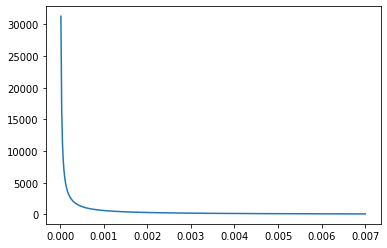

In [109]:
plt.plot(tau_list, F_center)

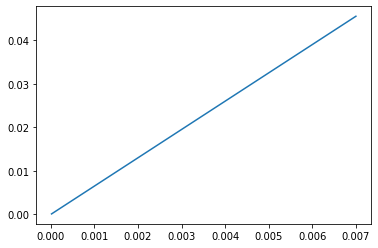

In [107]:
plt.plot(tau_list, FF_amp)

(array([215, 216, 217, 218, 219, 220, 221, 723, 724, 725, 726, 727, 728,
       729, 730]),)


21.699999999999992

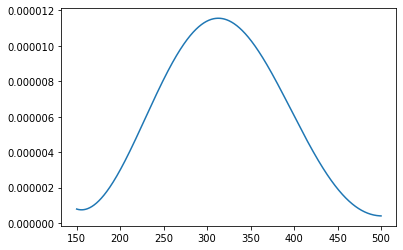

In [86]:
tau = 2e-3
N = 2
T = tau*N
ws = np.linspace(0.3/tau*2*np.pi,1/tau*2*np.pi,1001)
ff_data = [np.abs(FF(w, tau, N))**2 for w in ws]
plt.plot(ws/2/np.pi, ff_data)
idx = np.argmax(ff_data)
print(np.where((ff_data < np.max(ff_data)/2) & (ff_data > np.max(ff_data)/2.1)))
(ws[89]-ws[27])/2/np.pi

In [87]:
np.trapz(ff_data, ws)

0.012996040086274915

In [46]:
ws[27]/2/np.pi

151.3

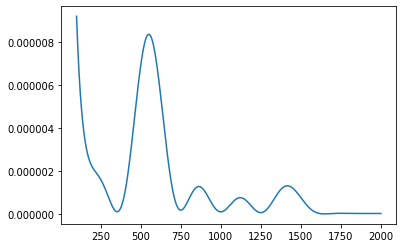

In [19]:
tau = 1e-3
N = 4
T = tau*N
ws = np.linspace(100*2*np.pi,2e3*2*np.pi,1001)
plt.plot(ws/2/np.pi, [np.abs(FF(w, tau, N))**2 for w in ws])

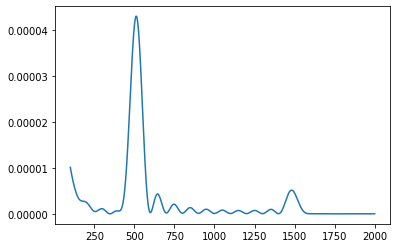

In [20]:
tau = 1e-3
N = 10
T = tau*N
ws = np.linspace(100*2*np.pi,2e3*2*np.pi,1001)
plt.plot(ws/2/np.pi, [np.abs(FF(w, tau, N))**2 for w in ws])